<a href="https://colab.research.google.com/github/buttersaltpepper/Financial-Data-Analytics/blob/main/PredictingVolatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Analysis on Market Volatility**
* I wanted to analyse the saying: "Sell in May and Go Away" to see the seasonal effect of volatility. 
* Uncertainty increases during May and June where companies release their earnings reports.
* I then did basic statistical feature selection by selecting features with high effect size and significant p-value. 
* This was then used to build an OLS model to predict volatility

* I will continue to improve this model as I study more about the markets



In [1]:
! pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,8)

import statsmodels.api as sm
from scipy import stats

from datetime import datetime, timedelta
import calendar

import yfinance as yf

In [3]:
tickers_list = ['SPY', 
                'VLUE', # VALUE
                'MDY', # MIDCAP
                'DVY', # DIVIDEND
                'EFA', # EAFE
                'IJR', # SMALL CAP
                'EEM', # EMERGY MARKETS
                'VGLT', # LONG-TERM TREASURY 
                'CL=F', # OIL

]

# **EDA**

In [4]:
data = yf.download(tickers_list)['Adj Close'].dropna()

[*********************100%***********************]  9 of 9 completed


In [109]:
# Shift foward
fwrd = 1
rolling_feature = 30

log_rets = np.log(data/data.shift(1))

df = log_rets.rolling(rolling_feature).std()

# df['SPY_vol'] = df.SPY
df['SPY_fwd_vol'] = df.SPY.shift(-fwrd)
df.drop('SPY', axis=1, inplace=True)
df.dropna(inplace=True)
df.head()

,CL=F,DVY,EEM,EFA,IJR,MDY,VGLT,VLUE,SPY_fwd_vol
Date,,,,,,,,,
2013-05-31 00:00:00-04:00,0.013765,0.007026,0.008688,0.008259,0.009489,0.008409,0.008017,0.009003,0.006091
2013-06-03 00:00:00-04:00,0.014012,0.006802,0.008698,0.008169,0.009428,0.008042,0.008129,0.009003,0.006189
2013-06-04 00:00:00-04:00,0.013971,0.006840,0.008938,0.008161,0.009648,0.008181,0.008213,0.009158,0.006591
2013-06-05 00:00:00-04:00,0.013970,0.007206,0.009439,0.008800,0.009719,0.008513,0.008541,0.010193,0.006762
2013-06-06 00:00:00-04:00,0.013386,0.007416,0.009512,0.008708,0.009767,0.008788,0.008529,0.009920,0.007070


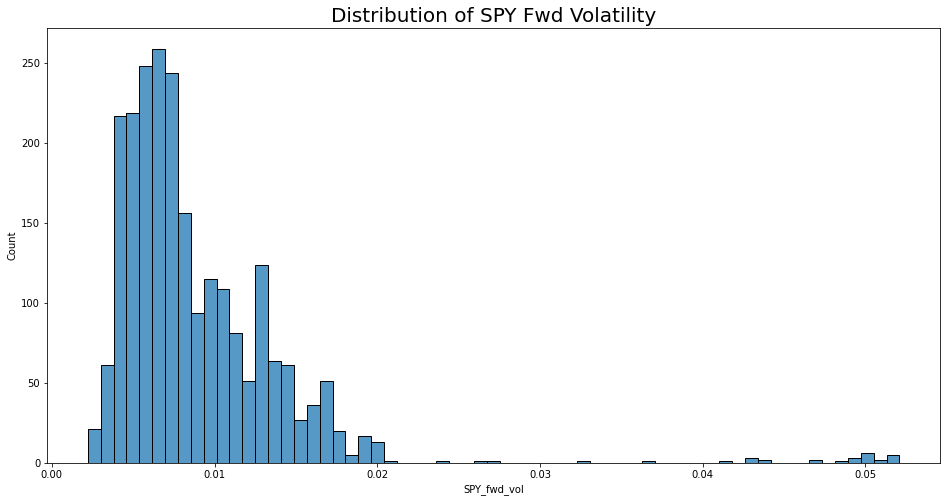

In [110]:
plt.title('Distribution of SPY Fwd Volatility', fontsize=20)
sns.histplot(df.SPY_fwd_vol);

## **"Sell in May and Go Away"**
* This is where i visualise and statistically analyse the impact of earnings seasons on market volatility

In [111]:
def weekinmonth(dates):
    firstday_in_month = dates - pd.to_timedelta(dates.day - 1, unit='d')
    return (dates.day-1 + firstday_in_month.weekday) // 7 + 1
    
df['mnth'] = df.index.month
df['wom'] = weekinmonth(df.index)

In [112]:
# Remove COVID outlier
post_covid = df[(df.index > '2020-6-1')]
pre_covid = df[(df.index < '2020-01-1')]

# train = post_covid
train = pd.concat([pre_covid, post_covid])

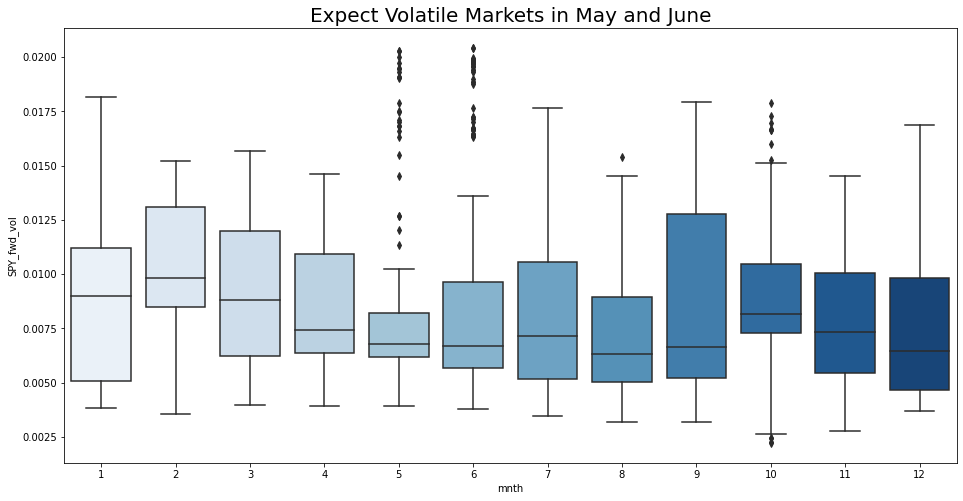

In [113]:
plt.title('Expect Volatile Markets in May and June', fontsize=20)
sns.boxplot(data=train, x='mnth', y='SPY_fwd_vol', palette='Blues')
plt.show()

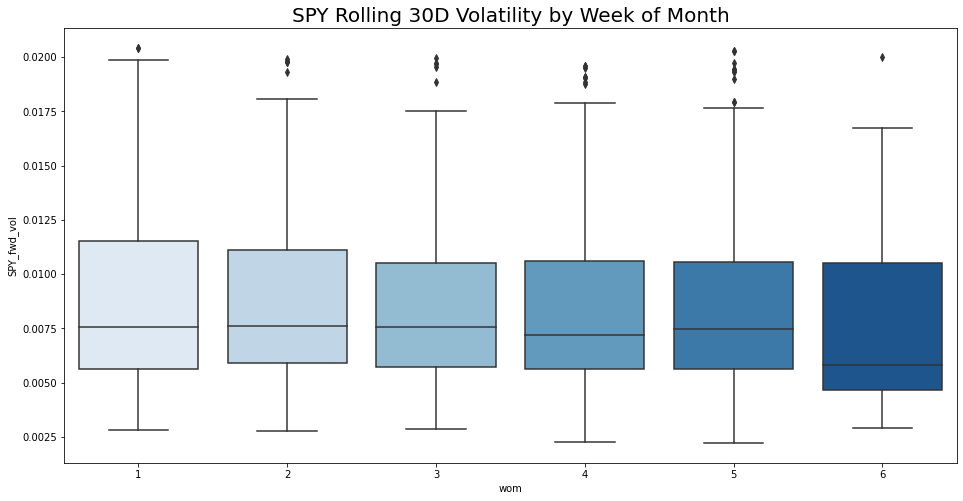

In [114]:
plt.title('SPY Rolling 30D Volatility by Week of Month', fontsize=20)
sns.boxplot(data=train, x='wom', y='SPY_fwd_vol', palette='Blues')
plt.show()

# **ANOVA Test**
* Volatility is statistically different in months
* This is expected due to earnings seasons in May-June period

In [115]:
anova_df = pd.DataFrame(columns = ['stat', '+/-', 'effect_size', 'p-value', 'skewness', 'kurtosis'])

for feat in train[['mnth', 'wom']]:
  anova_list = train.groupby(feat)['SPY_fwd_vol'].apply(list)
  f, p = stats.f_oneway(*anova_list)

  anova_df.loc[feat] = ['F', '', abs(round(f,3)), round(p,6), '', '']

anova_df.head()

,stat,+/-,effect_size,p-value,skewness,kurtosis
mnth,F,,7.580,0.000000,,
wom,F,,0.726,0.604009,,


## **Pearson Correlation $(r)$ and p-value**

In [116]:
pearson_df = pd.DataFrame(columns = ['stat', '+/-', 'effect_size', 'p-value', 'skewness', 'kurtosis'])

for col in train.drop('SPY_fwd_vol', axis=1):
  r,p = stats.pearsonr(train[col], train['SPY_fwd_vol'])
  s, k = stats.skew(train[col]), stats.kurtosis(train[col])
  pearson_df.loc[col] = ['r', np.sign(r), abs(round(r,3)), round(p,6), round(s,3), round(k,3)]

pearson_df.sort_values(by=['effect_size', 'p-value'], ascending=False)

,stat,+/-,effect_size,p-value,skewness,kurtosis
VLUE,r,1.0,0.911,0.000000,1.112,1.709
MDY,r,1.0,0.906,0.000000,1.174,1.829
DVY,r,1.0,0.794,0.000000,1.494,3.217
EFA,r,1.0,0.792,0.000000,1.043,1.349
IJR,r,1.0,0.781,0.000000,1.803,5.921
EEM,r,1.0,0.704,0.000000,0.688,0.109
CL=F,r,1.0,0.562,0.000000,1.516,5.541
VGLT,r,1.0,0.515,0.000000,0.741,-0.138
mnth,r,-1.0,0.125,0.000000,-0.113,-1.117
wom,r,-1.0,0.033,0.112369,-0.019,-1.020


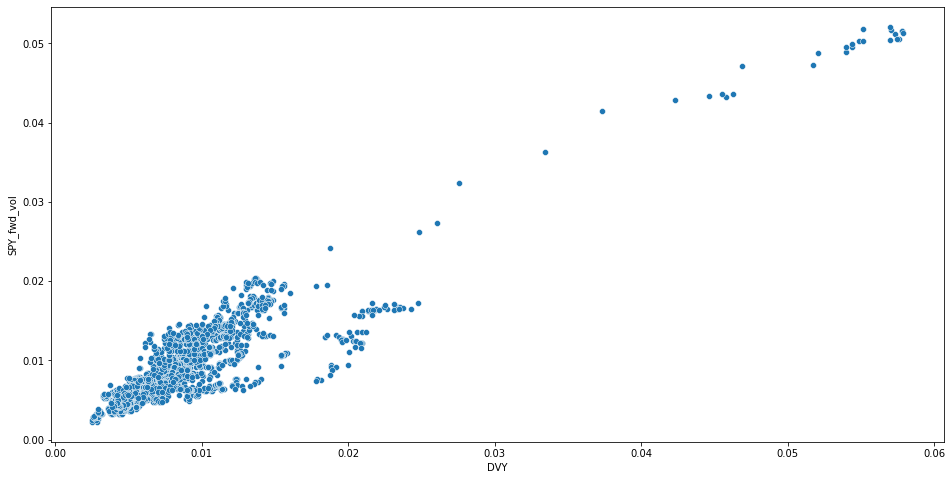

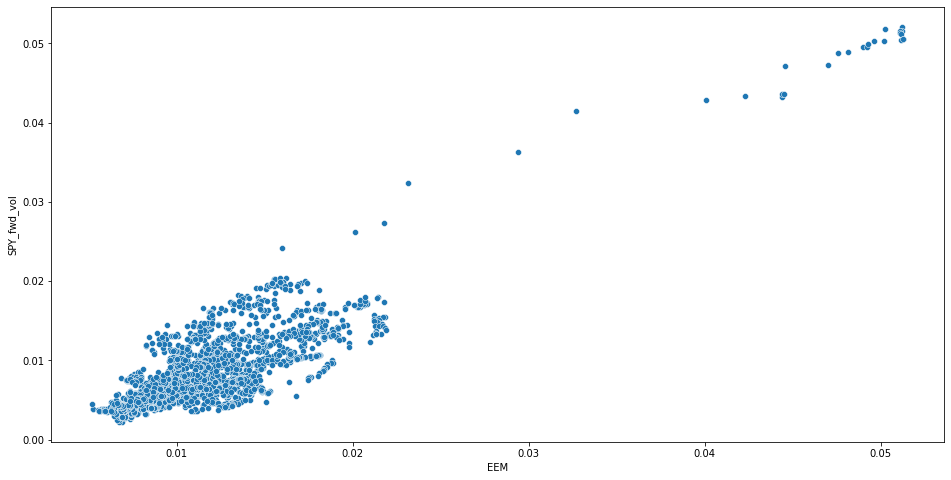

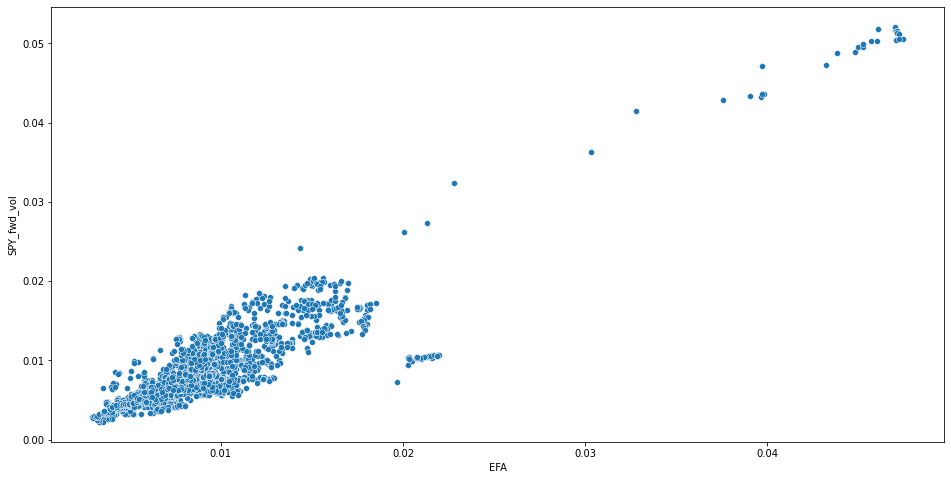

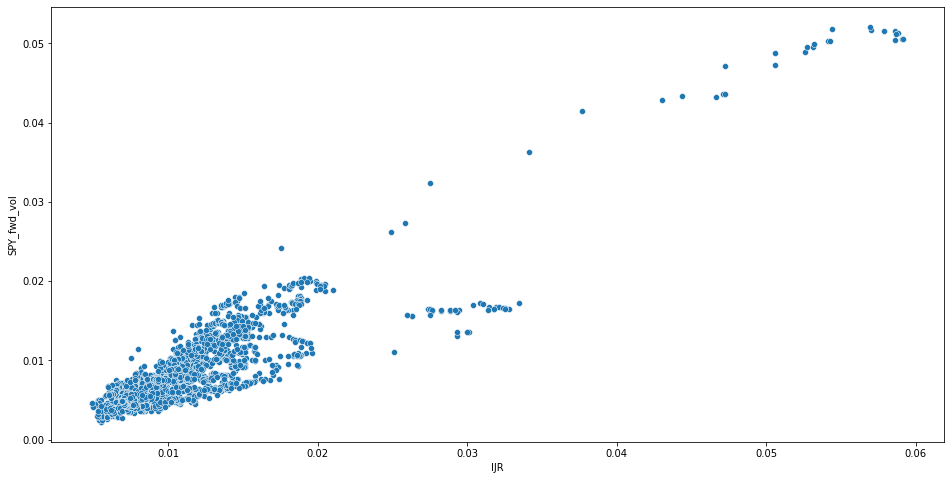

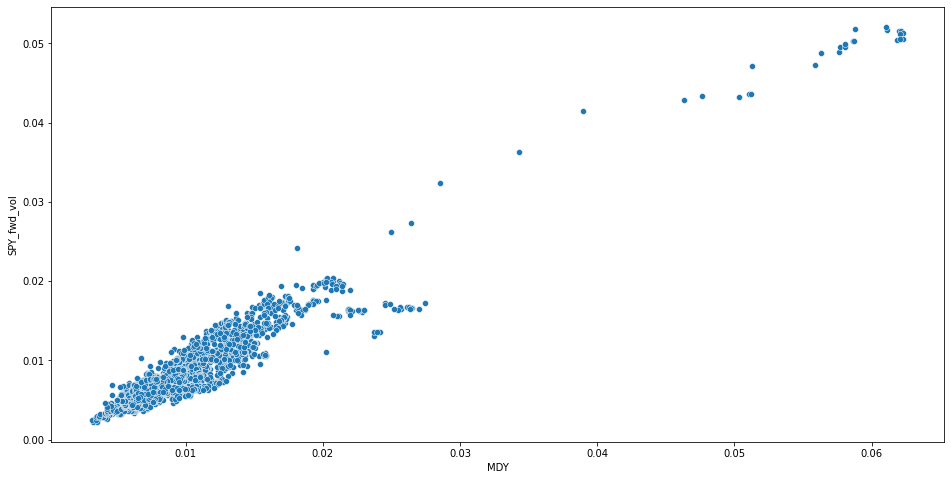

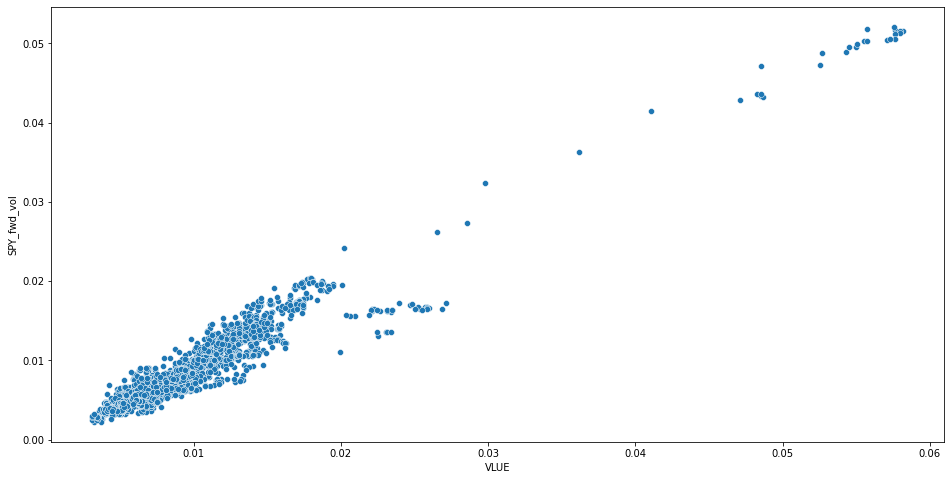

In [117]:
strong_r = list(pearson_df[pearson_df.effect_size > 0.6].index)

for col in strong_r:
  sns.scatterplot(x=df[col], y=df.SPY_fwd_vol)
  plt.show()

## **Statistical Feature Selection**

In [118]:
features_table = pd.concat([pearson_df[pearson_df.effect_size > 0.6], anova_df[anova_df['p-value'] < 0.05]])
features_table.sort_values(by=['effect_size', 'p-value'], ascending=[False, True])

,stat,+/-,effect_size,p-value,skewness,kurtosis
mnth,F,,7.580,0.0,,
VLUE,r,1.0,0.911,0.0,1.112,1.709
MDY,r,1.0,0.906,0.0,1.174,1.829
DVY,r,1.0,0.794,0.0,1.494,3.217
EFA,r,1.0,0.792,0.0,1.043,1.349
IJR,r,1.0,0.781,0.0,1.803,5.921
EEM,r,1.0,0.704,0.0,0.688,0.109


In [119]:
# Very skewed, so assumptions do not hold

# **OLS**
* Sklearn shuffles the data so statsmodels.api may be better for timeseries data

In [120]:
import statsmodels.api as sm

## Defining and splitting data set

In [121]:
features = train[features_table.index]

y = train[['SPY_fwd_vol']]
X = features.assign(const=1)

In [122]:
# manually split data set so it doesnt shuffle like Sklearn
tsize=  0.75

train_size = int(tsize * X.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

print(X_train.shape, y_train.shape, y_test.shape)

(1687, 8) (1687, 1) (563, 1)


## Fitting linear model

In [123]:
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            SPY_fwd_vol   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     2389.
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        04:47:33   Log-Likelihood:                 9195.7
No. Observations:                1687   AIC:                        -1.838e+04
Df Residuals:                    1679   BIC:                        -1.833e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
DVY            0.1016      0.027      3.788      0.0

## Prediction

In [124]:
train_prediction = results.predict(X_train)
test_prediction = results.predict(X_test)

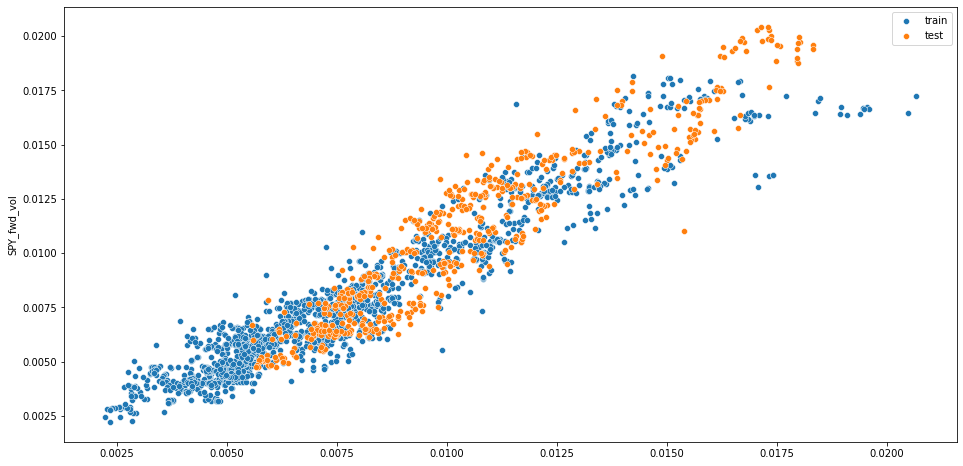

In [125]:
sns.scatterplot(x=train_prediction, y=y_train.SPY_fwd_vol, label='train')
sns.scatterplot(x=test_prediction, y=y_test.SPY_fwd_vol, label='test')

plt.show()

0.001440462670754512


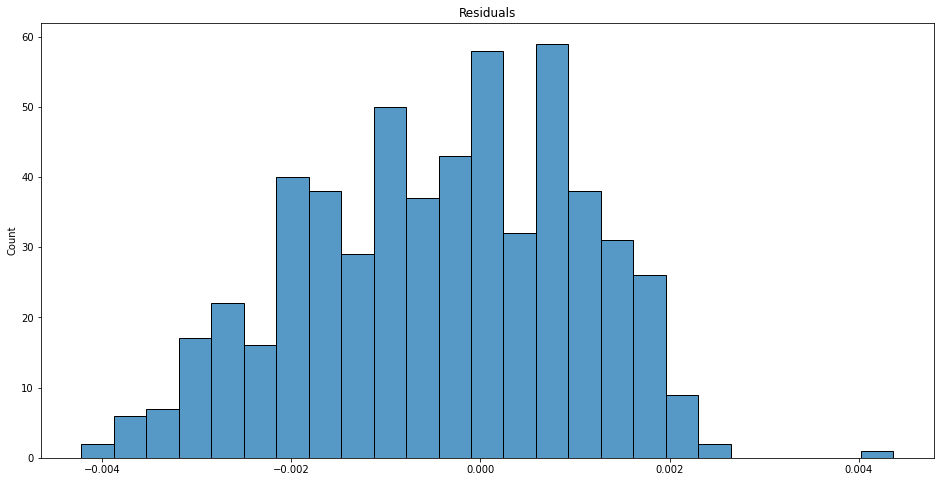

In [126]:
plt.title('Residuals')
sns.histplot(test_prediction - y_test.SPY_fwd_vol, bins=25);

print(np.std(test_prediction - y_test.SPY_fwd_vol))

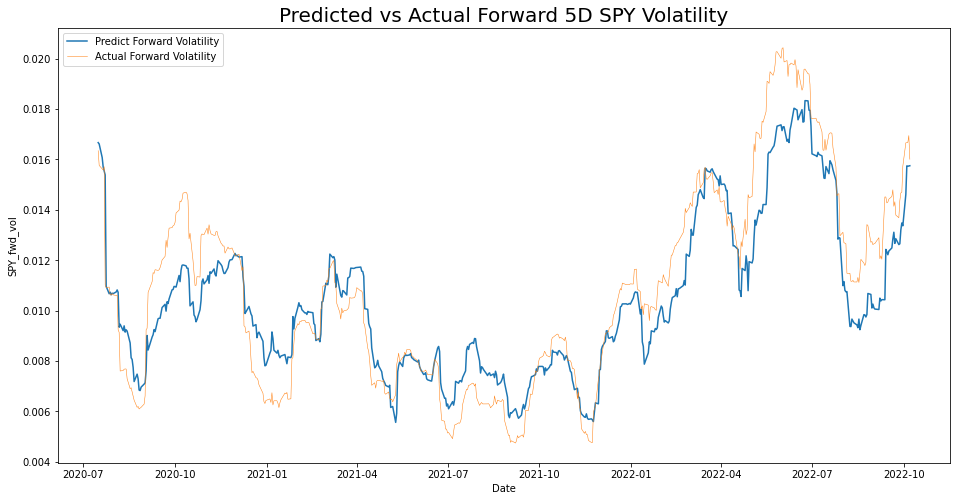

In [127]:
plt.title('Predicted vs Actual Forward 5D SPY Volatility', fontsize=20)


sns.lineplot(x=test_prediction.index, y=test_prediction, label='Predict Forward Volatility')
sns.lineplot(x=y_test.index, y=y_test.SPY_fwd_vol, linewidth=.5, label='Actual Forward Volatility')
plt.show()